In [15]:
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

warnings.filterwarnings('ignore')

### Loading the data

In [16]:
data = pd.read_csv("data_arrhythmia.csv", delimiter=';')
y_s = data.iloc[:, -1]
data.drop(data.columns[len(data.columns) - 1], axis=1, inplace=True)

### Data analysis

In [17]:
data.replace('?', np.NaN, inplace=True)

In [18]:
simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
data = pd.DataFrame(simple_imputer.fit_transform(data))
y_s.groupby(y_s).size()

diagnosis
1     245
2      44
3      15
4      15
5      13
6      25
7       3
8       2
9       9
10     50
14      4
15      5
16     22
Name: diagnosis, dtype: int64

In [ ]:
# remove examples of classes with few examples
# necessary if using SMOTE
to_delete = pd.concat([y_s[y_s == 8], y_s[y_s == 7], y_s[y_s == 14], y_s[y_s == 15]])
original_data = data
original_y_s = y_s
data = original_data.drop(to_delete.index)
y_s = original_y_s.drop(labels=to_delete.index)

### Splitting into training and testing sets, scaling the data and PCA

In [19]:
unscaled_train_X, unscaled_test_X, train_y, test_y = train_test_split(data, y_s, train_size=0.80, stratify=y_s)

resampler = RandomOverSampler()
unscaled_train_X, train_y = resampler.fit_resample(unscaled_train_X, train_y)

scaler = StandardScaler().fit(unscaled_train_X)
train_X = scaler.transform(unscaled_train_X)
test_X = scaler.transform(unscaled_test_X)

pca = PCA(n_components=150).fit(train_X)

train_data = pca.transform(train_X)
test_data = pca.transform(test_X)

In [20]:
train_y.groupby(train_y).size()

diagnosis
1     196
2     196
3     196
4     196
5     196
6     196
7     196
8     196
9     196
10    196
14    196
15    196
16    196
Name: diagnosis, dtype: int64

# Classification

### SVM

{'C': 0.1, 'degree': 2, 'kernel': 'linear'}
0.6923076923076923
0.6923076923076923


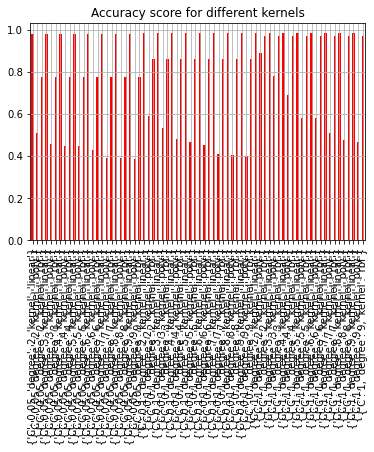

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVC

model = SVC()
parameters = {'kernel': ['linear', 'poly', 'rbf'], 'C': [0.05, 0.1, 1], 'degree': range(2, 10)}
k_fold = KFold(n_splits=5)

clf = GridSearchCV(model, parameters, cv=5, return_train_score=True)
clf.fit(train_data, train_y)
cv_results = clf.cv_results_
print(clf.best_params_)
print(accuracy_score(test_y, clf.predict(test_data)))
print(clf.score(test_data, test_y))

pd.Series( cv_results['mean_test_score'], cv_results['params']).plot(kind="bar",
                                                                    title="Accuracy score for different kernels",
                                                                    color='red', grid=True)
plt.show()


### Logistic regression

{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.6813186813186813


<AxesSubplot:title={'center':'Accuracy score for different solver'}>

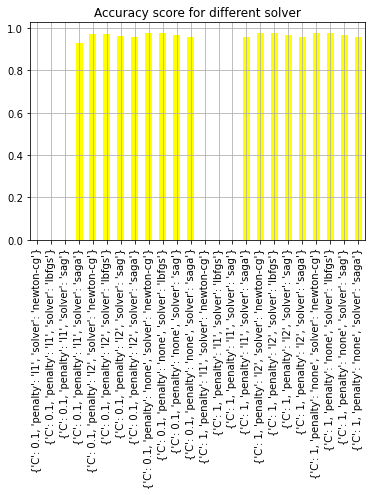

In [31]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
parameters = {'penalty': ('l1', 'l2', 'none'), 'C': [0.1, 1],
              'solver': ('newton-cg', 'lbfgs', 'sag', 'saga')}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(train_data, train_y)
cv_results = clf.cv_results_
print(clf.best_params_)
print(accuracy_score(test_y, clf.predict(test_data)))

pd.Series(cv_results['mean_test_score'], cv_results['params']).plot(kind="bar",
                                                                    title="Accuracy score for different solver",
                                                                    color='yellow',
                                                                    grid='bool')

### KNN

{'algorithm': 'ball_tree', 'n_neighbors': 1}
0.5054945054945055


<AxesSubplot:title={'center':'Accuracy score for different hyperparameters'}>

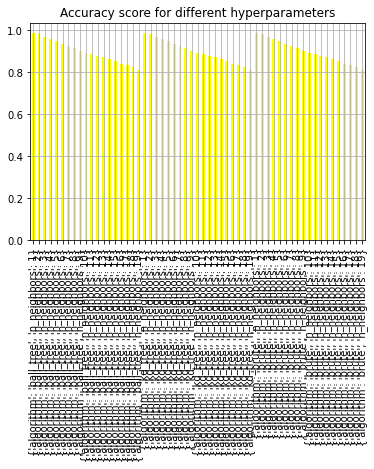

In [33]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
parameters = {'n_neighbors': range(1, 20), 'algorithm': ('ball_tree', 'kd_tree', 'brute')}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(train_data, train_y)
cv_results = clf.cv_results_
print(clf.best_params_)
print(accuracy_score(test_y, clf.predict(test_data)))

pd.Series(cv_results['mean_test_score'], cv_results['params']).plot(kind="bar",
                                                                    title="Accuracy score for different hyperparameters",
                                                                    color='yellow',
                                                                    grid='bool')
plt.show()

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
parameters = {'n_estimators': [1, 100, 125, 150, 200], 'criterion': ('gini', 'entropy')}
k_fold = KFold(n_splits=5)

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(train_data, train_y)
print(clf.best_params_)
print(clf.score(test_data, test_y))